In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import lightning as L


class VAE(nn.Module): 
    def __init__(self, in_channels: int, encoding_dim=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.act4 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.act5 = nn.ReLU()
        
        self.mu = nn.Linear(256, encoding_dim)
        self.logvar = nn.Linear(256, encoding_dim)
        
        self.encoder = nn.Sequential(
            self.conv1,
            self.act1,
            self.conv2,
            self.act2,
            self.conv3,
            self.act3,
            self.conv4,
            self.act4,
            self.flatten,
            self.fc1,
            self.act5
        )

        self.fc_decoder = nn.Linear(encoding_dim, 128 * 5 * 5)
                        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, log_var):
        """
        Applies the reparameterization trick to sample Z.
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        # 3. Calculate Z: Z = mu + std * epsilon
        z = mu + eps * std
        return z

    def forward(self, x):
        ## 1. Encoding
        h = self.encoder(x) # h has shape (Batch_size, 256)
        mu = self.mu(h)
        log_var = self.logvar(h) # log_var has shape (Batch_size, encoding_dim)
        z = self.reparameterize(mu, log_var) # z has shape (Batch_size, encoding_dim)
        h_dec = F.relu(self.fc_decoder(z)) # h_dec has shape (Batch_size, 128*5*5)
        h_dec = h_dec.view(-1, 128, 5, 5) # Shape: (Batch_size, 128, 5, 5)
        reconstruction = self.decoder(h_dec) # reconstruction has shape (Batch_size, in_channels, H, W)
        return reconstruction, mu, log_var

from torchvision.datasets import MNIST
import numpy as np 

def preprocess(x):
    i = np.array(x)
    i = i / 255.0
    i = np.expand_dims(i, axis=0)
    return i

dataset = MNIST("/results/mgazda/MNIST", download=True, transform=preprocess)

model = VAE(1, 128).cuda()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
MAX_EPOCH=50
rec_loss = nn.MSELoss()
kl_divergence_weight = 1e-5

def kl_loss_function(mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl_loss
    
for epoch in range(MAX_EPOCH):
    loss_epoch = 0.0
    kl_epoch = 0.0
    rec_epoch = 0.0
    for x, y in dataloader:
        y = y.cuda()
        x = x.float().cuda()
        x_pred, mu, logvar = model(x)
        rec_l = rec_loss(x_pred, x)
        kl_l = kl_divergence_weight * kl_loss_function(mu, logvar)
        total_l = rec_l + kl_l
        loss_epoch += total_l.item()
        kl_epoch += kl_l.item()
        rec_epoch += rec_l.item()
        model.zero_grad()    
        total_l.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{MAX_EPOCH}, total_loss: {loss_epoch/len(dataloader)}, kl_loss: {kl_epoch/len(dataloader)}, rec_loss: {rec_epoch/len(dataloader)}")

Epoch 1/50, total_loss: 0.06178995700478554, kl_loss: 0.00675199048021071, rec_loss: 0.055037966507673265
Epoch 2/50, total_loss: 0.03634300921062628, kl_loss: 0.009807500067353248, rec_loss: 0.026535509151220323
Epoch 3/50, total_loss: 0.0317854310164849, kl_loss: 0.010269865256547928, rec_loss: 0.021515565762917202
Epoch 4/50, total_loss: 0.02864017743766308, kl_loss: 0.010311401417354742, rec_loss: 0.01832877602974574
Epoch 5/50, total_loss: 0.02634475869735082, kl_loss: 0.01017924004693826, rec_loss: 0.016165518648425737
Epoch 6/50, total_loss: 0.024648346112171808, kl_loss: 0.010025863859057427, rec_loss: 0.014622482245663803
Epoch 7/50, total_loss: 0.023439245558778445, kl_loss: 0.009920097730557124, rec_loss: 0.013519147833188375
Epoch 8/50, total_loss: 0.02261643767952919, kl_loss: 0.009881399238606293, rec_loss: 0.012735038441419601
Epoch 9/50, total_loss: 0.021999345087011655, kl_loss: 0.009841238951186338, rec_loss: 0.012158106125394504
Epoch 10/50, total_loss: 0.02154467723

# Lab 9: Variational Autoencoder (VAE)

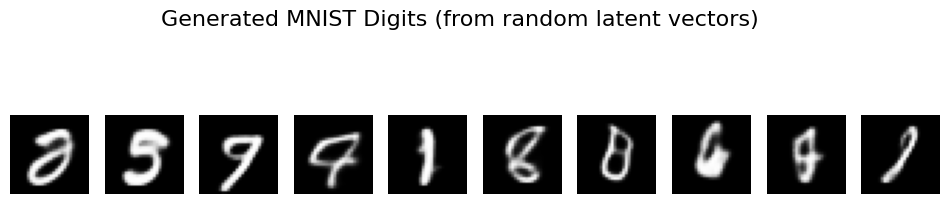

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()
N = 10
encoding_dim = model.mu.out_features 
z = torch.randn(N, encoding_dim).cuda() # Generate random samples from a standard normal distribution
with torch.no_grad(): # Disable gradient calculations for inference
    h_dec = F.relu(model.fc_decoder(z))
    h_dec = h_dec.view(N, 128, 5, 5)
    generated_images = model.decoder(h_dec)
generated_images = generated_images.cpu().numpy()
plt.figure(figsize=(12, 3))
for i in range(N):
    plt.subplot(1, N, i + 1)
    # MNIST images are (1, 28, 28), so squeeze to (28, 28) for display
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated MNIST Digits (from random latent vectors)', fontsize=16)
plt.show()

In [40]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import torch
import torch.nn.functional as F
import numpy as np

model.eval()

# --- Settings ---
NUM_SAMPLES = 30        # Total rows (pairs of digits)
STEPS = 20              # Columns (interpolation steps)
ROWS_PER_PAGE = 10      # How many rows to fit on one PDF page
encoding_dim = model.mu.out_features 

# --- 1. Generate Data ---
# Generate pairs of Start and End vectors
z_start = torch.randn(NUM_SAMPLES, encoding_dim).cuda()
z_end = torch.randn(NUM_SAMPLES, encoding_dim).cuda()

# Create interpolation steps
# alpha shape: (1, STEPS, 1)
alphas = torch.linspace(0, 1, STEPS).cuda().view(1, STEPS, 1)

# Broadcast to shape: (NUM_SAMPLES, STEPS, encoding_dim)
z_start_expanded = z_start.unsqueeze(1) 
z_end_expanded = z_end.unsqueeze(1)
z_interp = (1 - alphas) * z_start_expanded + alphas * z_end_expanded

# Flatten to (NUM_SAMPLES * STEPS, encoding_dim) for batch decoding
z_interp_flat = z_interp.view(-1, encoding_dim)

with torch.no_grad():
    # Decode all 600 images at once (30 rows * 20 steps)
    # Using your specific architecture logic:
    h_dec = F.relu(model.fc_decoder(z_interp_flat))
    
    # Handle reshape dynamically based on your model version (128 vs 64 channels)
    if h_dec.shape[1] == 128 * 5 * 5:
        h_dec = h_dec.view(-1, 128, 5, 5)
    else:
        # Fallback for robust 7x7 model
        h_dec = h_dec.view(-1, 64, 7, 7)
        
    generated_images = model.decoder(h_dec)
    
# Reshape back to (NUM_SAMPLES, STEPS, 28, 28)
images = generated_images.view(NUM_SAMPLES, STEPS, 28, 28).cpu().numpy()

# --- 2. Create PDF ---
filename = "vae_interpolations.pdf"

with PdfPages(filename) as pdf:
    # Iterate through chunks (pages)
    for page in range(0, NUM_SAMPLES, ROWS_PER_PAGE):
        fig = plt.figure(figsize=(STEPS, ROWS_PER_PAGE)) 
        
        # Plot the batch for this page
        for row in range(ROWS_PER_PAGE):
            actual_row_idx = page + row
            if actual_row_idx >= NUM_SAMPLES: break
            
            for col in range(STEPS):
                # Subplot index counts from 1
                ax = plt.subplot(ROWS_PER_PAGE, STEPS, (row * STEPS) + col + 1)
                
                plt.imshow(images[actual_row_idx, col], cmap='gray')
                plt.axis('off')
                
                # Label start and end of the first row on the page only
                if row == 0:
                    if col == 0: ax.set_title("Start", fontsize=8)
                    if col == STEPS - 1: ax.set_title("End", fontsize=8)

        plt.tight_layout(pad=0.5)
        pdf.savefig(fig)  # Save the current page
        plt.close()       # Clear memory

print(f"Successfully saved {NUM_SAMPLES} samples to '{filename}'")

Successfully saved 30 samples to 'vae_interpolations.pdf'
